# Per-capita GHG emissions of selected EU countries

This notebooks details the data preparation and plotting of the chart showing the per-capita emissions of greenhouse gases of selected EU member states.

## Load prerequisities

This notebooks uses the Tidyverse libraries and the `eurostat` package. To install these libraries, run the command `install.packages(c("eurostat", "tidyverse"))` in your R instance.

In [33]:
library(eurostat)
library(tidyverse)

theme_set(theme_void())

# Load our library with predefined categories of GHG emissions
# based on CRF codes.
source("../lib/R/emissions-utils.r")

## Parameters

In [34]:
selected_year <- 2023
# Vector of country codes to include in the chart.
selected_countries <- c("CZ", "DE", "FR", "HU", "PL", "SE", "SK")

# Names and colours for the individual emissions categories.
# Imported from emissions-utils.r above.
# Note that the order of categories here determines the order
# in the chart below – the first category is in the center,
# the others are placed around it in clockwise direction.
category_colours <- emission_category_colours
# Verify that the order is as expected:
cat("Order of categories:\n  - ")
names(category_colours) |> cat(sep = "\n  - ")

# Width/height of the largest square in the chart.
max_size <- 40
# Spacing between squares and indent of labels from square sides.
spacing <- 2
# Number of squares in each region: top, right, bottom.
layout <- c(2, 2, 2)

assertthat::assert_that(
  length(layout) == 3,
  msg = "Layout must have three components (top, right, bottom)"
)
assertthat::assert_that(
  1 + sum(layout) == length(category_colours),
  msg = "Sum of layout components must be same as number of categories"
)

Order of categories:
  - PowerHeat
  - Industry
  - Transport
  - Buildings
  - Agriculture
  - Waste
  - Other


[1] TRUE

[1] TRUE

## Emissions and population data

This visualization uses two datasets from the Eurostat database:

- [Greenhouse gas emissions by source sector](https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE) from EEA (product code `env_air_gge`) and
- [Population on 1 January](https://ec.europa.eu/eurostat/web/products-datasets/-/TPS00001) (product code `tps00001`).

In [ ]:
# Population numbers in the given year.
population <-
  get_eurostat(
    "tps00001",
    filters = list(time = selected_year),
    time_format = "num"
  ) |>
  select(
    CountryCode = geo,
    Population = values
  )

# Emissions numbers for all countries, selected sectors and years.
emissions <-
  get_eurostat(
    "env_air_gge",
    filters = list(
      airpol = "GHG",
      time = selected_year,
      unit = "MIO_T"
    ),
    time_format = "num"
  ) |>
  select(
    CountryCode = geo,
    Code = src_crf,
    Emissions = values
  ) |>
  # Join with population data and recalculate emissions
  # per capita (t CO₂/person).
  left_join(population, join_by(CountryCode)) |>
  replace_na(list(Emissions = 0)) |>
  fakta_calculate_emission_categories(values_col = Emissions) |>
  mutate(PerCapita = Emissions / (Population / 1e6)) |>
  mutate(
    # Note that the "Other" category may become slightly negative for
    # countries with very little emissions outside the main categories
    # due to rounding errors. Clamp emissions values to zero to prevent
    # issues later.
    PerCapita = pmax(0, PerCapita),
    # Enforce order of categories as declared above.
    across(Category, ~ factor(., levels = names(category_colours)))
  )

selected_emissions <- emissions |>
  filter(CountryCode %in% selected_countries)

## Chart plotting

We can now prepare the data for plotting. This is done by separating the categories into four groups, each of which will be plotted in a particular spot in the chart: center, top, right and bottom.

In [4]:
compute_square_coords <- function(x, y, width, spacing, label_position = "bottom") {
  if (label_position == "bottom") {
    label_vjust <- 0
    label_x <- x + width - spacing
    label_y <- y + width - spacing
  } else if (label_position == "top") {
    label_vjust <- 1
    label_x <- x + width - spacing
    label_y <- y + spacing
  } else {
    stop(glue::glue("Invalid label position ‘{label_position}’, ",
                    "expected ‘bottom’ or ‘top’"))
  }

  tibble(x, y, width, label_x, label_y, label_vjust)
}

# Helper function to prepare square coordinates for a single country.
make_squares_for_country <- function(.row, categories, size) {
  # We assume the y-inverted coordinate system:
  # x grows to the right, y grows down.

  # Center tile.
  width_center <- (width <- size(.row[[categories[[1]]]]))
  output <- tibble(Category = categories[[1]],
                   Coords = compute_square_coords(0, 0, width, spacing))

  # Top tiles.
  x <- width_center
  y <- -spacing
  for (category in rev(categories[[2]])) {
    width <- size(.row[[category]])
    x <- x - width
    output <- output |>
      rbind(tibble(Category = category,
                   Coords = compute_square_coords(x, y - width, width, spacing)))
    x <- x - spacing
  }

  # Right tiles.
  x <- width_center + spacing
  y <- width_center
  for (category in rev(categories[[3]])) {
    width <- size(.row[[category]])
    y <- y - width
    output <- output |>
      rbind(tibble(Category = category,
                   Coords = compute_square_coords(x, y, width, spacing)))
    y <- y - spacing
  }

  # Bottom tiles.
  x <- 0
  y <- width_center + spacing
  for (category in rev(categories[[4]])) {
    width <- size(max(0, .row[[category]]))
    # Skip zero-size tiles.
    if (width == 0) next
    output <- output |>
      rbind(tibble(Category = category,
                   Coords = compute_square_coords(x, y, width, spacing, "top")))
    x <- x + width + spacing
  }

  return(output |> unnest(Coords))
}

make_squares <- function(.data, layout, max_size, spacing = 1) {
  # Maximum amount of emissions in the whole dataset.
  max_value <- max(.data$Value, na.rm = TRUE)
  # Size (width/height) scale for the squares.
  size <- \(x) sqrt(x / max_value) * max_size

  # Split categories into groups by position according to the layout.
  categories <- levels(.data$Category)
  groups <- cumsum(seq_along(categories) %in% cumsum(c(2, layout)))
  cats_split <- split(categories, groups) |> unname()

  wide <- .data |>
    select(CountryCode, Category, Value) |>
    pivot_wider(names_from = "Category", values_from = "Value") |>
    column_to_rownames("CountryCode")

  rownames(wide) |>
    # Calculate square coordinates for each country and category.
    map(function(CountryCode) {
      Squares <- make_squares_for_country(wide[CountryCode, ], cats_split, size)
      tibble(CountryCode, Squares)
    }) |>
    list_rbind() |>
    # Join in original data (emissions amounts).
    left_join(.data, join_by(CountryCode, Category))
}

The resulting data frame ready for plotting looks like this:

In [5]:
squares_data <- make_squares(selected_emissions, layout, max_size, spacing)

squares_data |>
  mutate(across(where(is.numeric), ~ round(.x, 2))) |>
  head(10)

CountryCode,Category,x,y,width,label_x,label_y,label_vjust,Population,Value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CZ,PowerHeat,0.00,0.00,39.12,37.12,37.12,0,10827529,3.11
CZ,Transport,8.29,-32.83,30.83,37.12,-4.00,0,10827529,1.93
CZ,Industry,-27.97,-36.26,34.26,4.29,-4.00,0,10827529,2.39
CZ,Agriculture,41.12,19.91,19.21,58.34,37.12,0,10827529,0.75
CZ,Buildings,41.12,-1.87,19.78,58.91,15.91,0,10827529,0.80
CZ,Other,0.00,41.12,5.60,3.60,43.12,1,10827529,0.06
CZ,Waste,7.60,41.12,15.91,21.51,43.12,1,10827529,0.51
DE,PowerHeat,0.00,0.00,31.66,29.66,29.66,0,83118501,2.04
DE,Transport,-0.40,-34.06,32.06,29.66,-4.00,0,83118501,2.09


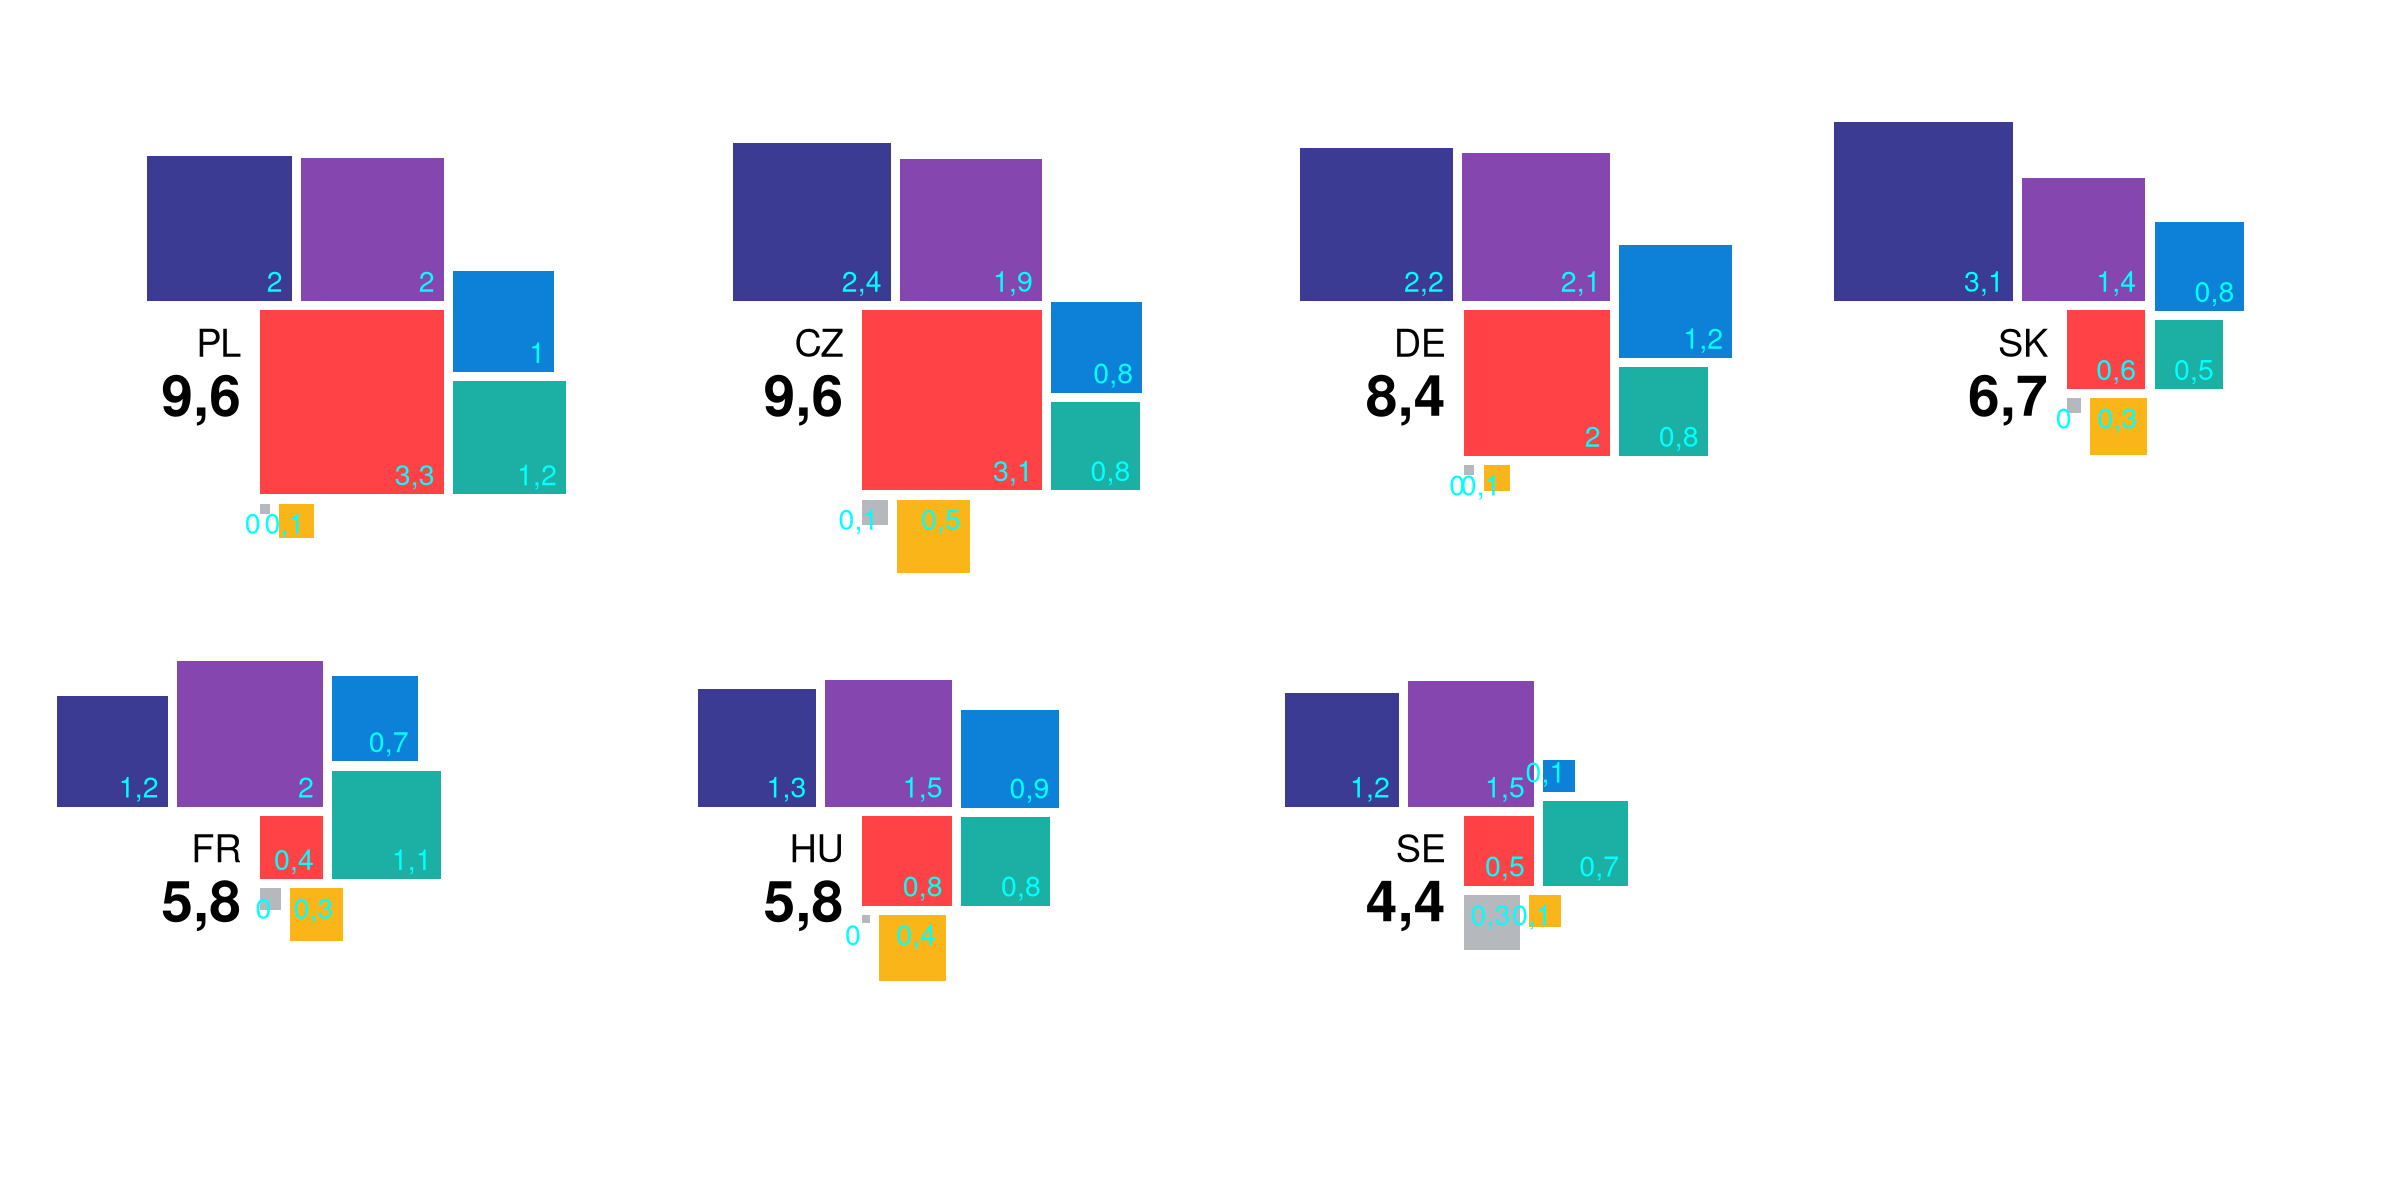

In [ ]:
# Use a comma for decimal separator.
options(repr.plot.width = 20, repr.plot.height = 10, OutDec = ",")

country_totals <- selected_emissions |>
  summarise(TotalPerCapita = sum(Value), .by = CountryCode) |>
  # Sort countries by total per-capita emissions.
  mutate(CountryCode = fct_reorder(CountryCode, -TotalPerCapita))

squares_plot <- squares_data |>
  # Sort countries by total per-capita emissions.
  mutate(CountryCode = fct_reorder(CountryCode, -Value, sum)) |>
  ggplot() +
  # Individual squares for each category.
  geom_rect(
    aes(
      xmin = x,
      ymin = y,
      xmax = x + width,
      ymax = y + width,
      fill = Category
    )
  ) +
  # Labels for values in each category.
  geom_text(
    aes(
      x = label_x,
      y = label_y,
      label = round(Value, 1),
      vjust = label_vjust
    ),
    colour = "cyan",
    hjust = 1,
    size = 6
  ) +
  # Country code labels.
  geom_text(
    aes(-4, 4, label = CountryCode),
    data  = country_totals,
    size  = 8,
    hjust = 1,
    vjust = 1
  ) +
  # Total country per-capita labels.
  geom_text(
    aes(-4, 14, label = round(TotalPerCapita, 1)),
    data = country_totals,
    size = 12,
    fontface = "bold",
    hjust = 1,
    vjust = 1
  ) +
  scale_fill_manual(values = category_colours) +
  facet_wrap(vars(CountryCode), nrow = 2) +
  scale_y_reverse() +
  coord_fixed(clip = "off") +
  theme(
    legend.position = "none",
    strip.text = element_blank()
  )

squares_plot

## SVG exports

The following code exports the two charts side-by-side into a single SVG file for further use:

In [13]:
svglite::svglite("../outputs/emissions-selected-countries.svg", width = 20, height = 10)
squares_plot
dev.off()

agg_record_889856138 
                   2